In [1]:
#Importando librerías útiles
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import cv2
import scipy.misc
from matplotlib import cm
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D 
from scipy import ndimage

In [2]:
#la direccion actual se encuentra en ~/CodigosAlejandro/
#Importando datos

datos  = np.loadtxt('data.dat', delimiter= ' ')
random = np.loadtxt('rand0.dat',delimiter= ' ')
print('número de datos: ', len(datos))
print('número de datos random: ', len(random))

número de datos:  32768
número de datos random:  32768


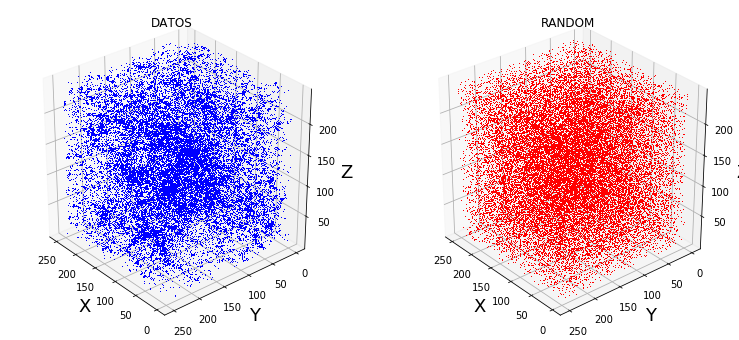

In [3]:
#Visualizando datos
fig = plt.figure(figsize=(13,6))
#subplot(columns, rows, position, projection)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(datos[:,0],datos[:,1],datos[:,2],',b')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('DATOS')
ax.view_init(30, 140)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(random[:,0],random[:,1],random[:,2],',r')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('RANDOM')
ax.view_init(30, 140)


plt.show()

In [4]:
#eliminando la 4 columna de ambos arrays de datos (estos objets ya son arrays de numpy desde el momento de importarlos con loadtxt)
data = datos.T[0:3].T
rand = random.T[0:3].T

In [101]:
#función para la construcción de la imagen del histograma
def imag(datos,titulo_figura,titulo_ejecolor,cmap):
    #creamos la figura con ese tamaño 1080px por 720px
    plt.figure(figsize=(10.8,7.2), dpi=100)

    #el Colormap (cmap) es usado para mapear datos escalares a colores
    #origin es el parametro que controla la posición donde se encuentra el origen
    # el parametro x representa los datos de la imagen, pueden ser datos escalares (matriz MXN )o imagenes con valores de RGB (MXNXL)
    # el parametro aspect controla si los pixeles son cuadrados ('equal') o son autoajustados de acuerdo a los ejes (no cuadrados 'auto')
    plt.imshow(datos, origin='lower',cmap=cmap, aspect='equal')
    #eje de color
    cax=plt.colorbar()
    #este metodo hace lineas de contorno, el primer parámetro son coordenadas de los valores de Z que es el siguiente parametro
    #el siguiente parametro son cuantas lineas de contorno se desea
    #el siguiente parametro cmap mapeo los niveles de color a grises, puede cambiarse a amarillo, u otros 
    #el siguiente parametro es el grosor de las lineas de controno, 
    plt.contour(datos, 20, cmap=plt.cm.gray, linewidths=.75)
    #titulo de los ejes
    plt.ylabel('$r_{\pi}$',fontsize = 18)
    plt.xlabel('$r_{p}$',fontsize = 18)
    #titulo de la figura
    plt.title(titulo_figura, fontsize = 16)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    #eje de color
    #labelpad indica cuanto espacio debe haber hacia la derecha antes de empezar el texto
    cax.set_label(titulo_ejecolor,labelpad = 5,fontsize = 18)
    plt.plot()

In [6]:
#Función de correlación Landy-Szalay
def estimador_LS(DD, RR, DR):
    return (DD - 2*DR + RR)/RR

In [7]:
#Función de correlación de Hamiltonn
def estimador_HAM(DD, RR, DR):
    return ((DD*RR)/(DR**2) - 1)

In [106]:
#Función principal
def calcular_histogramas2D(puntosD, puntosR, nbins, xmin, xmax, ymin, ymax):
    #nbins es el numero de particiones en el intervalo [lim_inf, lim_sup]
    #Variables de control para los histogramas
    DD = np.zeros((nbins,nbins))
    DR = np.zeros((nbins,nbins))
    RR = np.zeros((nbins,nbins))
    n = 0 #variable auxiliar

    for (i,j) in zip(puntosD, puntosR):
        n+=1
        #Para DD
        r_ab = i - puntosD[n:] #la diferencia entre los puntos pivote y el resto de datos en D (MATRIZ)
        r_ab_DD = np.sqrt(r_ab[:,0]**2 + r_ab[:,1]**2 + r_ab[:,2]**2) # distancia rab entre los puntos anteriores (LISTA)
        r_paralelo_DD = abs(i[2] - puntosD[n:,2]) #tomando el eje Z como preferencial el R paralelo es solo la diferencia entre la coordenada z
        r_perpendicular_DD = np.sqrt(r_ab_DD**2 - r_paralelo_DD**2) # es trivial deducir esta relacion

        HDDdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_DD,r_perpendicular_DD, bins=nbins, range=([[xmin,xmax],[ymin, ymax]]))
        #La función histogram2d regresa una lista con los valores ordenados de la cantidad de distancias que se repiten en cada intervalo (bin) por cada eje y 
        # otras dos listas con los intervalos utilizados (bin_lst) en los dos ejes
        DD += 2*HDDdis_lst

        #Para RR, como se corre el for  en paralelo, no es necsario un nuevo contador, por eso empleamos n
        R_ab = j - puntosR[n:]
        r_ab_RR = np.sqrt(R_ab[:,0]**2 + R_ab[:,1]**2 + R_ab[:,2]**2)
        r_paralelo_RR = abs(j[2] - puntosR[n:,2])
        # r_paralelo_RR = np.absolute(np.dot(R_ab, r_unit_RR))
        r_perpendicular_RR = np.sqrt(r_ab_RR**2 - r_paralelo_RR**2)
        
        HRRdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_RR, r_perpendicular_RR, bins=nbins, range=([[xmin,xmax],[ymin, ymax]]))
        RR += 2*HRRdis_lst

    for k in puntosD:
        r_ab = k - puntosR
        r_ab_DR = np.sqrt(r_ab[:,0]**2 + r_ab[:,1]**2 + r_ab[:,2]**2)
        r_paralelo_DR = abs(k[2] - puntosR[:,2])
        #r_paralelo_DR = np.absolute(np.dot(r_ab, r_unit_DR))
        r_perpendicular_DR = np.sqrt(r_ab_DR**2  - r_paralelo_DR**2)
        
        HDRdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_DR, r_perpendicular_DR, bins=nbins, range=([[xmin, xmax],[ymin, ymax]]))
        DR += HDRdis_lst
    
    return DD, DR, RR, xbins_lst, ybins_lst

In [107]:
#Código principal
to = timer()
DD, DR, RR, x, y = calcular_histogramas2D(data, rand, 30, 0, 180, 0, 180)
tf = timer()

print(f'Finalizado en: {round(tf-to,2)} segundos')

Finalizado en: 227.11 segundos


In [108]:
#calculando los estimadores
eps_LS_2d = estimador_LS(DD,RR,DR)
eps_HAM_2d = estimador_HAM(DD, RR, DR)

In [113]:
#¿Para que es este pedazo de codigo?
top = np.max(eps_LS_2d[np.where(eps_LS_2d < 0.05)])
down = np.min(eps_LS_2d[np.where(eps_LS_2d > -0.05)])
eps_LS_2d[np.where(eps_LS_2d > 0.05)] = top
eps_LS_2d[np.where(eps_LS_2d < -0.05)] = down

#Se hace un filtrado de la imagen a graficar, este filtro difumina los bordes y elimina ruido 
#el kernel mas usado para la convolución es de dimensiones 3x3
datos_filtrados = cv2.blur(eps_LS_2d,(3,3))

#también podría hacerse un filtro para eliminar ruido GAussiano, el tercer parametro es el valor de signa
#blur_OH = cv2.GaussianBlur(eps_LS_2d,(3,3),0)

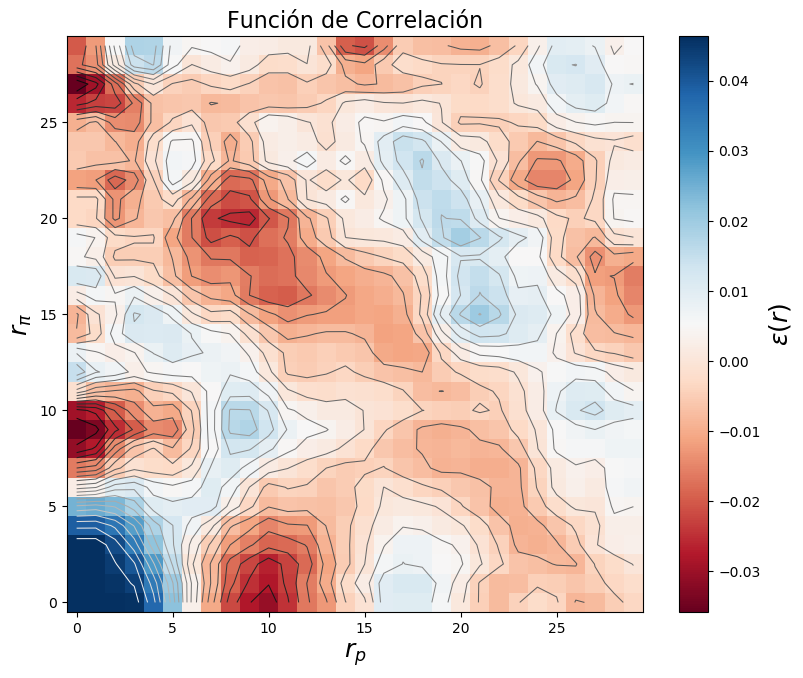

In [114]:
#construir imagen
imag(datos_filtrados,'Función de Correlación','$\epsilon(r)$',cmap='RdBu')

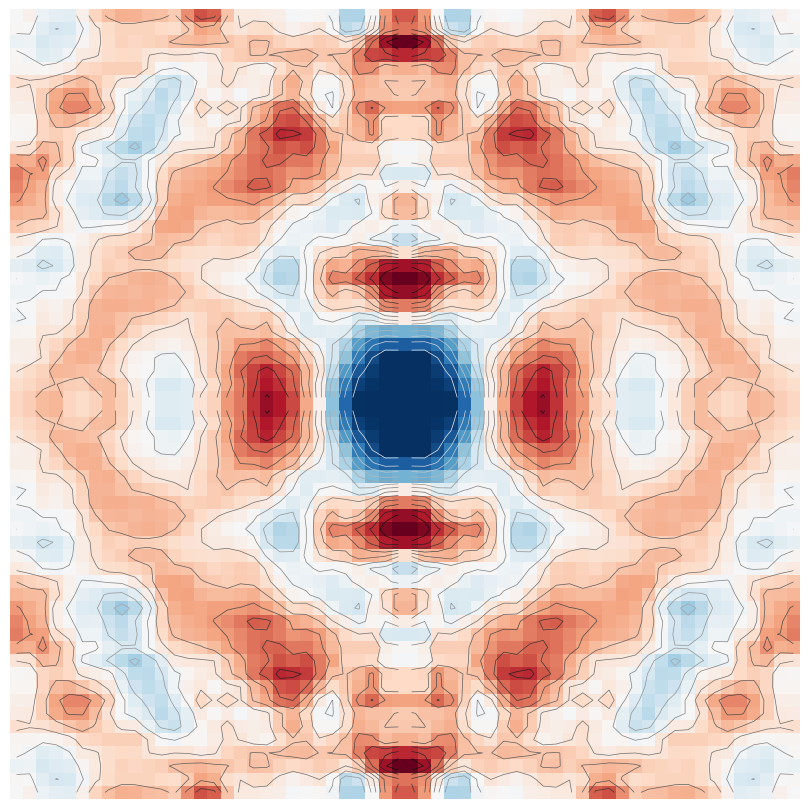

In [156]:
#visualizando imagen anterior rotada y 4 veces
fig = plt.figure(figsize = (8.2,8.2), dpi= 100, constrained_layout=False, tight_layout=True)
gs1 = gridspec.GridSpec(2, 2, wspace=0, hspace=0, figure=fig)
ax1 = plt.subplot(gs1[0])
rotated_img = ndimage.rotate(np.rot90(datos_filtrados), 90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,15,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax2 = plt.subplot(gs1[1])
rotated_img = ndimage.rotate(datos_filtrados.T,90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,15,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax3 = plt.subplot(gs1[2])
rotated_img = ndimage.rotate(datos_filtrados.T,-90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,15,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax4 = plt.subplot(gs1[3])
rotated_img = ndimage.rotate(datos_filtrados, 0)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,15,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
plt.show()